In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q -U bitsandbytes transformers peft accelerate datasets scipy einops evaluate trl rouge_score


There's an error that: "rouge_score does not have a __version__ attribute."

To fix this error, I will upgrade the module and print using print("Rouge Score version:", importlib.metadata.version("rouge-score"))" instead of "print("Rouge Score version:", rouge_score.__version__)". This requires me to import "importlib.metadata".

In [3]:
import bitsandbytes
import transformers
import peft
import accelerate
import datasets
import scipy
import einops
import evaluate
import trl
import rouge_score
import importlib.metadata

!pip install --upgrade rouge-score

print("BitsAndBytes version:", bitsandbytes.__version__)
print("Transformers version:", transformers.__version__)
print("PEFT version:", peft.__version__)
print("Accelerate version:", accelerate.__version__)
print("Datasets version:", datasets.__version__)
print("Scipy version:", scipy.__version__)
print("Einops version:", einops.__version__)
print("Evaluate version:", evaluate.__version__)
print("TRL version:", trl.__version__)

# Replaced print command
print("Rouge Score version:", importlib.metadata.version("rouge-score"))

ERROR:bitsandbytes.cextension:Could not load bitsandbytes native library: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cpu.so)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 85, in <module>
    lib = get_native_library()
          ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/bitsandbytes/cextension.py", line 72, in get_native_library
    dll = ct.cdll.LoadLibrary(str(binary_path))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 454, in LoadLibrary
    return self._dlltype(name)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4

BitsAndBytes version: 0.45.2
Transformers version: 4.49.0
PEFT version: 0.14.0
Accelerate version: 1.4.0
Datasets version: 3.3.1
Scipy version: 1.15.2
Einops version: 0.8.1
Evaluate version: 0.4.3
TRL version: 0.15.1
Rouge Score version: 0.1.2


In [4]:
import os
# disable Weights and Biases
os.environ['WANDB_DISABLED']="true"

In [5]:
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig
)
from tqdm import tqdm
from trl import SFTTrainer
import torch
import time
import pandas as pd
import numpy as np
from huggingface_hub import interpreter_login

interpreter_login()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) y


There's an error that: "No module named 'pynvml'"

To fix this error, I will use "!pip install nvidia-ml-py3"

In [6]:
!pip install nvidia-ml-py3

from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")

In [7]:
# https://huggingface.co/datasets/neil-code/dialogsum-test
huggingface_dataset_name = "neil-code/dialogsum-test"
dataset = load_dataset(huggingface_dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1999
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 499
    })
})

In [8]:
dataset['train'][0]



{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [9]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )
device_map = {"": 0}

Here below I replaced original phi-2 with GPT-2 model which classifies under "any small model for training"

Here was an error due to google colab's limited time for GPU usage in free version, so I had to fix it by commenting out manually specifying the device map and quantization_config. Therefore I could use ".to("cpu")".

In [10]:
model_name='gpt2'
original_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                      #device_map=device_map,
                                                      #quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

original_model.to("cpu")

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [11]:
# https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa
tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True,padding_side="left",add_eos_token=True,add_bos_token=True,use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

In [12]:
#print_gpu_utilization()


In [13]:
eval_tokenizer = AutoTokenizer.from_pretrained(model_name, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

def gen(model,p, maxlen=100, sample=True):
    if isinstance(p, str):
        p = [p]
    toks = eval_tokenizer(p, return_tensors="pt", padding=True, truncation=True).to("cpu")
    res = model.generate(**toks, max_new_tokens=maxlen, do_sample=sample,num_return_sequences=1,temperature=0.1,num_beams=1,top_p=0.95,).to('cpu')
    return eval_tokenizer.batch_decode(res,skip_special_tokens=True)

Here I have had an error because I had to run with cpu so I added toks.to("cpu") instead of toks.to("CUDA") in above.

In [14]:
%%time
from transformers import set_seed
seed = 42
set_seed(seed)

index = 10

prompt = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

formatted_prompt = f"Instruct: Summarize the following conversation.\n{prompt}\nOutput:\n"
res = gen(original_model,formatted_prompt,100,)
#print(res[0])
output = res[0].split('Output:\n')[1]

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{formatted_prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


---------------------------------------------------------------------------------------------------
INPUT PROMPT:
Instruct: Summarize the following conversation.
#Person1#: Happy Birthday, this is for you, Brian.
#Person2#: I'm so happy you remember, please come in and enjoy the party. Everyone's here, I'm sure you have a good time.
#Person1#: Brian, may I have a pleasure to have a dance with you?
#Person2#: Ok.
#Person1#: This is really wonderful party.
#Person2#: Yes, you are always popular with everyone. and you look very pretty today.
#Person1#: Thanks, that's very kind of you to say. I hope my necklace goes with my dress, and they both make me look good I feel.
#Person2#: You look great, you are absolutely glowing.
#Person1#: Thanks, this is a fine party. We should have a drink together to celebrate your birthday
Output:

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# attends Brian's birthday pa

In [15]:
def create_prompt_formats(sample):
    """
    Format various fields of the sample ('instruction','output')
    Then concatenate them using two newline characters
    :param sample: Sample dictionnary
    """
    INTRO_BLURB = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
    INSTRUCTION_KEY = "### Instruct: Summarize the below conversation."
    RESPONSE_KEY = "### Output:"
    END_KEY = "### End"

    blurb = f"\n{INTRO_BLURB}"
    instruction = f"{INSTRUCTION_KEY}"
    input_context = f"{sample['dialogue']}" if sample["dialogue"] else None
    response = f"{RESPONSE_KEY}\n{sample['summary']}"
    end = f"{END_KEY}"

    parts = [part for part in [blurb, instruction, input_context, response, end] if part]

    formatted_prompt = "\n\n".join(parts)
    sample["text"] = formatted_prompt

    return sample

Error in preprocess_batch because incorrect data format for tokenization so I added "padding=True".

In [16]:
# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def get_max_length(model):
    conf = model.config
    max_length = None
    for length_setting in ["n_positions", "max_position_embeddings", "seq_length"]:
        max_length = getattr(model.config, length_setting, None)
        if max_length:
            print(f"Found max lenth: {max_length}")
            break
    if not max_length:
        max_length = 1024
        print(f"Using default max length: {max_length}")
    return max_length


def preprocess_batch(batch, tokenizer, max_length):
    """
    Tokenizing a batch
    """
     # Ensure 'batch["text"]' is a list of strings and not nested lists
    batch["text"] = [str(text) for text in batch["text"]]

    return tokenizer(
        batch["text"],
        max_length=max_length,
        truncation=True,
        padding=True,
    )

In [17]:
print(f"Train dataset length: {len(dataset['train'])}")
print(f"Validation dataset length: {len(dataset['validation'])}")

Train dataset length: 1999
Validation dataset length: 499


Error in filtering so using truncating.

In [18]:
from functools import partial

# SOURCE https://github.com/databrickslabs/dolly/blob/master/training/trainer.py
def preprocess_dataset(tokenizer: AutoTokenizer, max_length: int,seed, dataset):
    """Format & tokenize it so it is ready for training
    :param tokenizer (AutoTokenizer): Model Tokenizer
    :param max_length (int): Maximum number of tokens to emit from tokenizer
    """

    # Add prompt to each sample
    print("Preprocessing dataset...")
    dataset = dataset.map(create_prompt_formats)#, batched=True)

    _preprocessing_function = partial(preprocess_batch, max_length=max_length, tokenizer=tokenizer)
    dataset = dataset.map(
        _preprocessing_function,
        batched=True,
        remove_columns=['id', 'topic', 'dialogue', 'summary'],
        #load_from_cache_file=False
    )

    # Filter out samples that have input_ids exceeding max_length
    dataset = dataset.filter(lambda sample: len(sample["input_ids"]) < max_length)

    # Print dataset length after filtering
    print(f"Dataset length after filtering: {len(dataset)}")

    # Shuffle dataset
    dataset = dataset.shuffle(seed=seed)

    return dataset

In [19]:
#print_gpu_utilization()


In [20]:
# ## Pre-process dataset
max_length = get_max_length(original_model)
print(max_length)

train_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['train'])
eval_dataset = preprocess_dataset(tokenizer, max_length,seed, dataset['validation'])

print(f"Shapes of the datasets:")
print(f"Training: {train_dataset.shape}")
print(f"Validation: {eval_dataset.shape}")
print(train_dataset)

Found max lenth: 1024
1024
Preprocessing dataset...
Sample 0 input_ids length: 1024
Sample 1 input_ids length: 1024
Sample 2 input_ids length: 1024
Sample 3 input_ids length: 1024
Sample 4 input_ids length: 1024
Sample 5 input_ids length: 1024
Sample 6 input_ids length: 1024
Sample 7 input_ids length: 1024
Sample 8 input_ids length: 1024
Sample 9 input_ids length: 1024
Sample 10 input_ids length: 1024
Sample 11 input_ids length: 1024
Sample 12 input_ids length: 1024
Sample 13 input_ids length: 1024
Sample 14 input_ids length: 1024
Sample 15 input_ids length: 1024
Sample 16 input_ids length: 1024
Sample 17 input_ids length: 1024
Sample 18 input_ids length: 1024
Sample 19 input_ids length: 1024
Sample 20 input_ids length: 1024
Sample 21 input_ids length: 1024
Sample 22 input_ids length: 1024
Sample 23 input_ids length: 1024
Sample 24 input_ids length: 1024
Sample 25 input_ids length: 1024
Sample 26 input_ids length: 1024
Sample 27 input_ids length: 1024
Sample 28 input_ids length: 1024
S

In [21]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 124439808
all model parameters: 124439808
percentage of trainable model parameters: 100.00%


In [22]:
print(original_model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


Here I got an error "Target modules {'dense', 'k_proj', 'v_proj', 'q_proj'} not found in the base model"

To fix this, I change configuration to suit GPT-2 model with Attention layers and Feed-forward layers.

In [23]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

config = LoraConfig(
    r=32, #Rank
    lora_alpha=32,
    target_modules=[
        'attn.c_attn',
        'attn.c_proj',
        'mlp.c_fc',
        'mlp.c_proj'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
original_model.gradient_checkpointing_enable()

# 2 - Using the prepare_model_for_kbit_training method from PEFT
original_model = prepare_model_for_kbit_training(original_model)

peft_model = get_peft_model(original_model, config)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [24]:
print(print_number_of_trainable_model_parameters(peft_model))


trainable model parameters: 4718592
all model parameters: 129158400
percentage of trainable model parameters: 3.65%


There's an error "No label_names provided for model class PeftModelForCausalLM. Since PeftModel hides base models input arguments, if label_names is not given, label_names can't be set automatically within Trainer."

To fix this, I will tell the Trainer that "labels" will be used for computing the loss.

There was also an error with optim="paged_adamw_8bit" when running with cpu so I fixed that by running with just optim="adamw_torch_fused" instead.

Also, I have optimized parameters for faster training and better results.

In [25]:
output_dir = './peft-dialogue-summary-training/final-checkpoint'
import transformers
import torch

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    label_names=["labels"],  # ✅ Fixed
    warmup_steps=1,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,  # ✅ Reduced for speed
    max_steps=500,
    learning_rate=2e-4,
    optim="adamw_torch_fused",
    logging_steps=50,  # ✅ Logs less often
    save_strategy="steps",
    save_steps=200,  # ✅ Saves less often
    eval_strategy="steps",  # ✅ Fixed deprecated argument
    eval_steps=50,  # ✅ Evaluates less often
    do_eval=True,
    gradient_checkpointing=False,  # ✅ Disabled for speed
    fp16=True,  # ✅ Enables mixed precision
    report_to="none",
    overwrite_output_dir=True,
    group_by_length=True,
    remove_unused_columns=False,
)


print(type(peft_model))
print(f"Dataset size after filtering: {len(dataset)}")


#peft_model.config.use_cache = False
#peft_model = torch.compile(peft_model)

peft_trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=peft_training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

print("Trainer initialized successfully!")

<class 'peft.peft_model.PeftModelForCausalLM'>
Dataset size after filtering: 3
Trainer initialized successfully!


Here I had an error "Unable to create tensor" which I fixed by activating truncation and padding in gen funcion earlier with "padding=True, truncation=True,".

In [26]:
peft_training_args.device
peft_trainer.train()


IndexError: Invalid key: 0 is out of bounds for size 0

The was an obvious error with the path name which I corrected by creating a new model repository (phi-2-dialogsum-finetuned) in Hugging Face under my profile.

In [ ]:
from huggingface_hub import login
login()  # Enter your HF token

In [ ]:
# Upload Model & Tokenizer
peft_model.push_to_hub("donbena/gpt2-finetuned") # Replaced with my username
tokenizer.push_to_hub("donbena/gpt2-finetuned") # Replaced with my username

Below is the screenshot of the model in Hugging face.

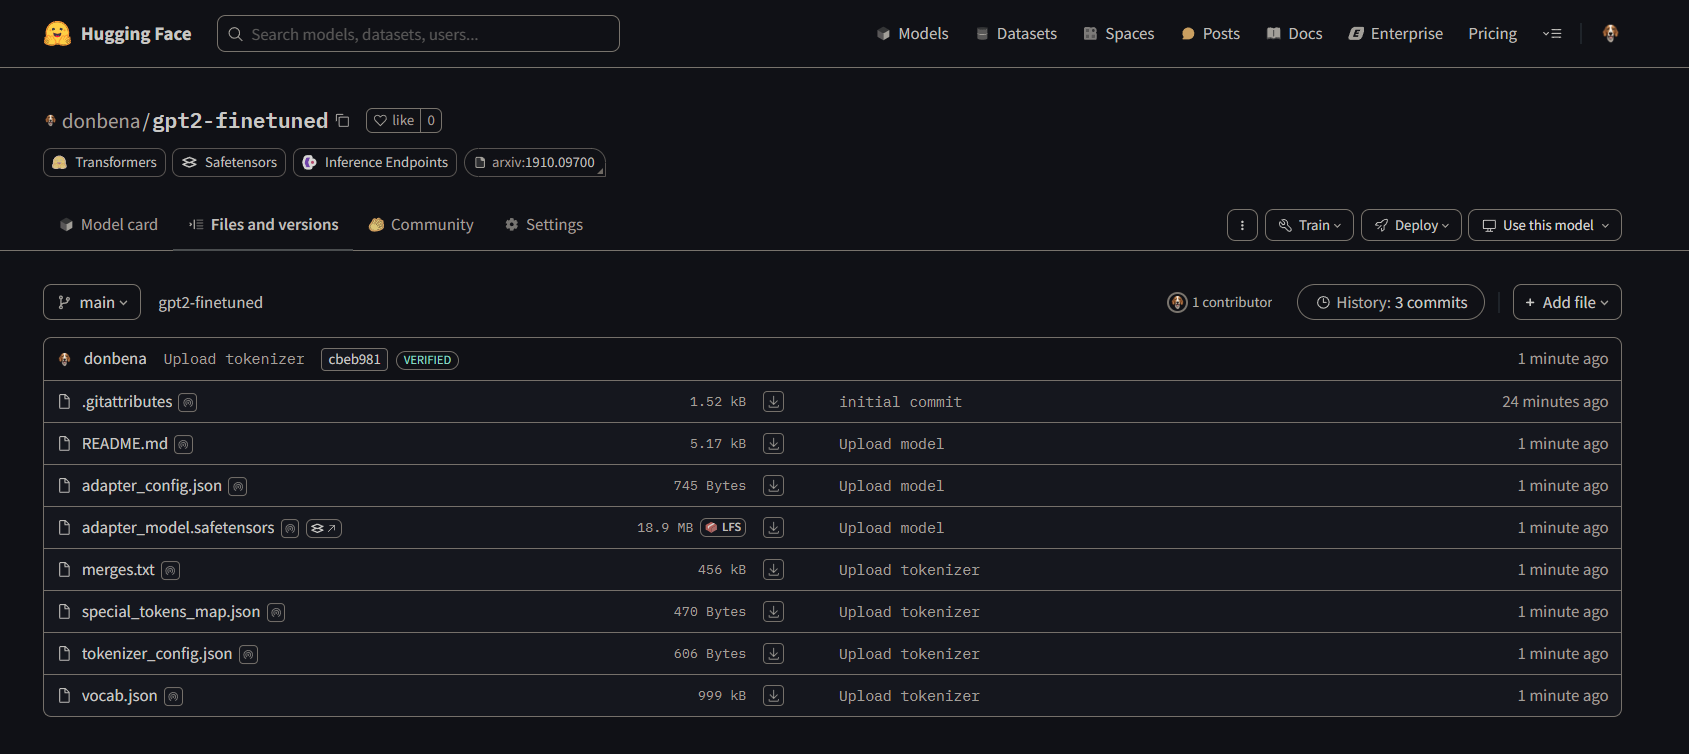

In [ ]:
print_gpu_utilization()
del original_model
del peft_trainer
torch.cuda.empty_cache()
print_gpu_utilization()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "gpt2"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

In [ ]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

Fixed error below by replacing the model path with he newly created model pushed to the hugging face.

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "donbena/gpt2-finetuned",torch_dtype=torch.float16,is_trainable=False)

In [ ]:
%%time
from transformers import set_seed
set_seed(seed)

index = 10
dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

peft_model_res = gen(ft_model,prompt,100,)
peft_model_output = peft_model_res[0].split('Output:\n')[1]
#print(peft_model_output)
prefix, success, result = peft_model_output.partition('#End')

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'PEFT MODEL:\n{prefix}')

In [ ]:
original_model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                                      device_map='auto',
                                                      quantization_config=bnb_config,
                                                      trust_remote_code=True,
                                                      use_auth_token=True)

In [ ]:
import pandas as pd

dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    human_baseline_text_output = human_baseline_summaries[idx]
    prompt = f"Instruct: Summarize the following conversation.\n{dialogue}\nOutput:\n"

    original_model_res = gen(original_model,prompt,100,)
    original_model_text_output = original_model_res[0].split('Output:\n')[1]

    peft_model_res = gen(ft_model,prompt,100,)
    peft_model_output = peft_model_res[0].split('Output:\n')[1]
    #print(peft_model_output)
    peft_model_text_output, success, result = peft_model_output.partition('#End')


    original_model_summaries.append(original_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'peft_model_summaries'])
df

In [ ]:
!pip install rouge_score


In [ ]:
import evaluate

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('PEFT MODEL:')
print(peft_model_results)

In [ ]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')